In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.sparse as sps
import scipy.io as io
import time
from scipy.sparse.linalg import svds
from sklearn import preprocessing

In [2]:
# read interactions file
train_final = pd.read_csv('../../input/train_final.csv', sep = '\t')
train_final['interaction'] = 1.0
train_final = train_final.sort_values(['playlist_id', 'track_id'], ascending=[True, True])
numberInteractions = train_final.shape[0]
print(train_final.iloc[:20,])

        playlist_id  track_id  interaction
770769         7569    162463          1.0
925571         7569    421750          1.0
912580         7569    795606          1.0
852833         7569   1195736          1.0
287048         7569   2227105          1.0
92449          7569   2634448          1.0
519471         7569   2654612          1.0
173680         7569   2693660          1.0
903004         7569   2861386          1.0
863056         7614    415173          1.0
278077         7614   1384962          1.0
394480         7614   1609224          1.0
615615         7614   1614974          1.0
328664         7614   1714787          1.0
377085         7614   2141817          1.0
83840          7614   2285204          1.0
574199         7614   3361942          1.0
481594         7614   3504896          1.0
300753         7614   3711434          1.0
775317         7614   3833025          1.0


In [3]:
# read target playlists which should receive a recommendation
target_playlists = pd.read_csv('../../input/target_playlists.csv', sep = '\t')
print(target_playlists.head())
print(target_playlists.shape)

   playlist_id
0     10024884
1     10624787
2      4891851
3      4267369
4        65078
(10000, 1)


In [4]:
# read target tracks
target_tracks = list(pd.read_csv('../../input/target_tracks.csv', sep = '\t')['track_id'])
target_tracks

[1316175,
 3885714,
 3091270,
 226759,
 230596,
 1093284,
 2293453,
 2994241,
 2871264,
 93835,
 1123498,
 2374491,
 1074412,
 2853886,
 821071,
 2709648,
 2933818,
 346111,
 66103,
 3638141,
 232971,
 2848406,
 3783264,
 2842670,
 3581982,
 3171591,
 2245591,
 871828,
 2713603,
 1175043,
 106982,
 3102164,
 1553840,
 2057826,
 3557550,
 2363848,
 1253516,
 503539,
 2617340,
 1790258,
 2956696,
 193328,
 303129,
 3608340,
 950730,
 1855305,
 3777248,
 1076555,
 1150702,
 3419354,
 726682,
 465271,
 2602747,
 1762406,
 1605205,
 1759620,
 2021651,
 709968,
 2972914,
 259990,
 1349043,
 3522735,
 1773876,
 2862475,
 106083,
 2820187,
 3612400,
 2881368,
 2083728,
 1935536,
 1585141,
 1444202,
 1248376,
 881160,
 1709123,
 1154985,
 2443976,
 2304545,
 4700754,
 1080646,
 1550729,
 793276,
 4486831,
 3868340,
 2642609,
 548753,
 2168844,
 5546,
 472924,
 1604514,
 3013929,
 2213950,
 717927,
 1245649,
 3250648,
 8287,
 881469,
 3242407,
 132362,
 2466040,
 2433491,
 426884,
 2843330,
 990

In [5]:
# read tracks_final which should receive a recommendation
tracks_final = pd.read_csv('../../input/tracks_final.csv', sep = '\t')
print(tracks_final.head())
print(tracks_final.shape)

   track_id  artist_id  duration  playcount   album  \
0   2972914        144    224000       49.0     [7]   
1   2750239        246    157000        1.0     [8]   
2   1550729        144    217000      554.0     [9]   
3   2169950        144    207000      200.0     [9]   
4   1903709        144    198000        5.0  [None]   

                                     tags  
0     [54087, 1757, 1718, 116712, 189631]  
1   [189631, 3424, 177424, 46208, 205245]  
2   [54087, 109806, 46869, 183258, 54337]  
3  [54087, 70618, 207003, 109806, 116712]  
4   [54087, 81223, 116712, 215342, 71028]  
(100000, 6)


In [6]:
playlist_id = list(train_final['playlist_id'])
track_id = list(train_final['track_id'])
interaction = list(train_final['interaction'])
print(playlist_id[:10])
print(track_id[:10])
print(interaction[:10])

[7569, 7569, 7569, 7569, 7569, 7569, 7569, 7569, 7569, 7614]
[162463, 421750, 795606, 1195736, 2227105, 2634448, 2654612, 2693660, 2861386, 415173]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [7]:
playlist_id_unique = list(set(playlist_id))
track_id_unique = list(set(track_id))
playlist_id_unique.sort()
playlist_id_unique = pd.DataFrame(playlist_id_unique)
playlist_id_unique.reset_index(level=0, inplace=True)
playlist_id_unique.columns = ['index_playlist', 'playlist_id']
#track_id_unique.sort()
track_id_unique = pd.DataFrame(track_id_unique)
track_id_unique.reset_index(level=0, inplace=True)
track_id_unique.columns = ['index_track', 'track_id']
print(track_id_unique.head())
print(playlist_id_unique.head())

   index_track  track_id
0            0   1048594
1            1   1835030
2            2   3670041
3            3   1048604
4            4   2140848
   index_playlist  playlist_id
0               0         7569
1               1         7614
2               2         7641
3               3         7692
4               4         7816


In [8]:
train_intermediate = train_final.merge(playlist_id_unique, how='inner', on='playlist_id')
train_index = train_intermediate.merge(track_id_unique, how='inner', on='track_id')
train_index = train_index.sort_values(['playlist_id', 'track_id'], ascending=[True, True])
train_index

,playlist_id,track_id,interaction,index_playlist,index_track
0,7569,162463,1.0,0,61858
87,7569,421750,1.0,0,60603
116,7569,795606,1.0,0,3088
125,7569,1195736,1.0,0,55373
195,7569,2227105,1.0,0,97631
198,7569,2634448,1.0,0,4366
241,7569,2654612,1.0,0,12139
253,7569,2693660,1.0,0,26564
263,7569,2861386,1.0,0,92451
298,7614,415173,1.0,1,57789


In [9]:
tracks_final = tracks_final.merge(track_id_unique, how='inner', on='track_id')
tracks_final

,track_id,artist_id,duration,playcount,album,tags,index_track
0,2972914,144,224000,49.0,[7],"[54087, 1757, 1718, 116712, 189631]",33185
1,2750239,246,157000,1.0,[8],"[189631, 3424, 177424, 46208, 205245]",48519
2,1550729,144,217000,554.0,[9],"[54087, 109806, 46869, 183258, 54337]",25542
3,2169950,144,207000,200.0,[9],"[54087, 70618, 207003, 109806, 116712]",67095
4,1903709,144,198000,5.0,[None],"[54087, 81223, 116712, 215342, 71028]",25293
5,2256817,144,218000,2.0,[9],"[54087, 109806, 189631, 49166, 116712]",60630
6,2561768,928,223000,249.0,[26],"[50764, 4425, 11056, 205245, 81223]",78911
7,474864,928,193000,73.0,[22],"[205245, 81223, 11056, 267, 3982]",82945
8,1378455,928,304000,73.0,[22],"[11056, 205245, 81223, 189631, 84597]",24956
9,1523190,928,206000,10.0,[22],"[205245, 11056, 81223, 4425, 189631]",82838


In [10]:
index_playlist = list(train_index['index_playlist'])
index_track = list(train_index['index_track'])
interaction = list(train_index['interaction'])
print(index_playlist[:10])
print(index_track[:10])
print(interaction[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[61858, 60603, 3088, 55373, 97631, 4366, 12139, 26564, 92451, 57789]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [11]:
URM_all = sps.coo_matrix((interaction, (index_playlist, index_track)))
URM_all = URM_all.tocsr()
URM_all

<45649x99999 sparse matrix of type '<type 'numpy.float64'>'
	with 1040522 stored elements in Compressed Sparse Row format>

In [12]:
import json
tracks_final['tags'] = tracks_final.tags.apply(json.loads)

In [13]:
tags_list = []
for index, row in tracks_final.iterrows():
    if len(row['tags']) != 0:
        for i in row['tags']:
            tags_list.append([row['index_track'], i, 1])

In [14]:
test = pd.DataFrame(tags_list)
test.columns = ['index_track', 'tag', 'interaction']
test

,index_track,tag,interaction
0,33185,54087,1
1,33185,1757,1
2,33185,1718,1
3,33185,116712,1
4,33185,189631,1
5,48519,189631,1
6,48519,3424,1
7,48519,177424,1
8,48519,46208,1
9,48519,205245,1


In [16]:
test.columns = ['index_track', 'tag', 'interaction']
track_list = list(test['index_track'])
tag_list = list(test['tag'])
interaction_list = list(test['interaction'])
print interaction_list[0:10]
print type(interaction)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
<type 'list'>


In [17]:
le = preprocessing.LabelEncoder()
le.fit(tag_list)
taglist_icm = le.transform(tag_list)
print(taglist_icm.max())
print(type(taglist_icm))

31897
<type 'numpy.ndarray'>


In [18]:
test['tag'].nunique()
print len(interaction_list)
print len(interaction)
print len(index_track)
print len(index_playlist)
print len(track_id)
print len(track_list)
print len(taglist_icm)
print track_list[0:10]
print index_track[0:10]

483496
1040522
1040522
1040522
1040522
483496
483496
[33185, 33185, 33185, 33185, 33185, 48519, 48519, 48519, 48519, 48519]
[61858, 60603, 3088, 55373, 97631, 4366, 12139, 26564, 92451, 57789]


In [19]:
ICM_all = sps.coo_matrix((interaction_list, (track_list, taglist_icm)))
ICM_all

<99999x31898 sparse matrix of type '<type 'numpy.int64'>'
	with 483496 stored elements in COOrdinate format>

In [20]:
features_per_item = (ICM_all > 0).sum(axis=1)
items_per_feature = (ICM_all > 0).sum(axis=0)

print(features_per_item.shape)
print(items_per_feature.shape)

(99999, 1)
(1, 31898)


In [21]:
features_per_item = np.array(features_per_item).squeeze()
items_per_feature = np.array(items_per_feature).squeeze()

print(features_per_item.shape)
print(items_per_feature.shape)

(99999,)
(31898,)


In [22]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

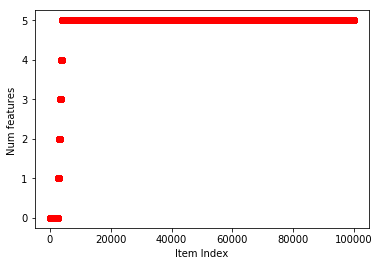

In [23]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(features_per_item, 'ro')
pyplot.ylabel('Num features ')
pyplot.xlabel('Item Index')
pyplot.show()

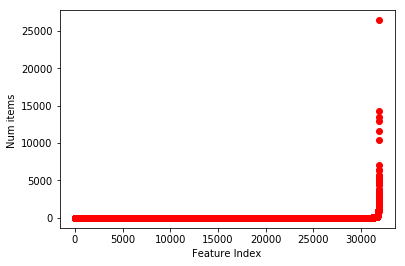

In [24]:
pyplot.plot(items_per_feature, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Feature Index')
pyplot.show()

In [25]:
train_test_split = 0.80

numInteractions = URM_all.nnz


train_mask = np.random.choice([True,False], numInteractions, [train_test_split, 1-train_test_split])

index_playlist = np.array(index_playlist)
index_track = np.array(index_track)
interaction = np.array(interaction)


URM_train = sps.coo_matrix((interaction[train_mask], (index_playlist[train_mask], index_track[train_mask])))
URM_train = URM_train.tocsr()

test_mask = np.logical_not(train_mask)

URM_test = sps.coo_matrix((interaction[test_mask], (index_playlist[test_mask], index_track[test_mask])))
URM_test = URM_test.tocsr()

def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

def MAP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    map_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return map_score

def evaluate_algorithm(URM_test, recommender_object, at=5):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_MAP = 0.0
    
    num_eval = 0


    for i,playlist_id_id in  enumerate(playlist_id_unique):
        
        if i % 500 == 0:
            print("Playlist %d of %d" % (i, len(playlist_id_unique)))

        relevant_items = URM_test[playlist_id_id].indices
        
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(playlist_id_, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_MAP += MAP(recommended_items, relevant_items)


    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    cumulative_MAP /= num_eval
    
    print("Recommender performance is: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, cumulative_MAP))

In [26]:
class BasicItemKNNRecommender(object):
    """ ItemKNN recommender with cosine similarity and no shrinkage"""

    def __init__(self, URM, k=50, shrinkage=100, similarity='cosine'):
        self.dataset = URM
        self.k = k
        self.shrinkage = shrinkage
        self.similarity_name = similarity
        if similarity == 'cosine':
            self.distance = Cosine(shrinkage=self.shrinkage)
        elif similarity == 'pearson':
            self.distance = Pearson(shrinkage=self.shrinkage)
        elif similarity == 'adj-cosine':
            self.distance = AdjustedCosine(shrinkage=self.shrinkage)
        else:
            raise NotImplementedError('Distance {} not implemented'.format(similarity))

    def __str__(self):
        return "ItemKNN(similarity={},k={},shrinkage={})".format(
            self.similarity_name, self.k, self.shrinkage)

    def fit(self, X):
        item_weights = self.distance.compute(X)
        
        item_weights = check_matrix(item_weights, 'csr') # nearly 10 times faster
        print("Converted to csr")
        
        # for each column, keep only the top-k scored items
        # THIS IS THE SLOW PART, FIND A BETTER SOLUTION        
        values, rows, cols = [], [], []
        nitems = self.dataset.shape[1]
        for i in range(nitems):
            if (i % 10000 == 0):
                print("Track %d of %d" % (i, nitems))
                
            this_item_weights = item_weights[i,:].toarray()[0]
            top_k_idx = np.argsort(this_item_weights) [-self.k:]
                        
            values.extend(this_item_weights[top_k_idx])
            rows.extend(np.arange(nitems)[top_k_idx])
            cols.extend(np.ones(self.k) * i)
        self.W_sparse = sps.csc_matrix((values, (rows, cols)), shape=(nitems, nitems), dtype=np.float32)

    def recommend(self, playlist_id_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.dataset[playlist_id_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        # rank items
        ranking = scores.argsort()[::-1]
        if exclude_seen:
            ranking = self._filter_seen(playlist_id_id, interaction)
            
        return ranking[:at]
    
    def _filter_seen(self, playlist_id_id, ranking):
        user_profile = self.dataset[playlist_id_id]
        seen = user_profile.indices
        unseen_mask = np.in1d(ranking, seen, assume_unique=True, invert=True)
        return ranking[unseen_mask]

In [27]:
def check_matrix(X, format='csc', dtype=np.float32):
    if format == 'csc' and not isinstance(X, sps.csc_matrix):
        return X.tocsc().astype(dtype)
    elif format == 'csr' and not isinstance(X, sps.csr_matrix):
        return X.tocsr().astype(dtype)
    elif format == 'coo' and not isinstance(X, sps.coo_matrix):
        return X.tocoo().astype(dtype)
    elif format == 'dok' and not isinstance(X, sps.dok_matrix):
        return X.todok().astype(dtype)
    elif format == 'bsr' and not isinstance(X, sps.bsr_matrix):
        return X.tobsr().astype(dtype)
    elif format == 'dia' and not isinstance(X, sps.dia_matrix):
        return X.todia().astype(dtype)
    elif format == 'lil' and not isinstance(X, sps.lil_matrix):
        return X.tolil().astype(dtype)
    else:
        return X.astype(dtype)

In [28]:
import scipy
class ISimilarity(object):
    """Abstract interface for the similarity metrics"""

    def __init__(self, shrinkage=10):
        self.shrinkage = shrinkage

    def compute(self, X):
        pass


class Cosine(ISimilarity):
    def compute(self, X):
        # convert to csc matrix for faster column-wise operations
        X = check_matrix(X, 'csc', dtype=np.float32)

        # 1) normalize the columns in X
        # compute the column-wise norm
        # NOTE: this is slightly inefficient. We must copy X to compute the column norms.
        # A faster solution is to  normalize the matrix inplace with a Cython function.
        Xsq = X.copy()
        Xsq.data **= 2
        norm = np.sqrt(Xsq.sum(axis=0))
        norm = np.asarray(norm).ravel()
        norm += 1e-6
        # compute the number of non-zeros in each column
        # NOTE: this works only if X is instance of sparse.csc_matrix
        col_nnz = np.diff(X.indptr)
        # then normalize the values in each column
        X.data /= np.repeat(norm, col_nnz)
        print("Normalized")

        # 2) compute the cosine similarity using the dot-product
        dist = X * X.T
        print("Computed")
        
        # zero out diagonal values
        dist = dist - sps.dia_matrix((dist.diagonal()[scipy.newaxis, :], [0]), shape=dist.shape)
        print("Removed diagonal")
        
        # and apply the shrinkage
        if self.shrinkage > 0:
            dist = self.apply_shrinkage(X, dist)
            print("Applied shrinkage")    
        
        return dist

    def apply_shrinkage(self, X, dist):
        # create an "indicator" version of X (i.e. replace values in X with ones)
        X_ind = X.copy()
        X_ind.data = np.ones_like(X_ind.data)
        # compute the co-rated counts
        co_counts = X_ind * X_ind.T
        # remove the diagonal
        co_counts = co_counts - sps.dia_matrix((co_counts.diagonal()[scipy.newaxis, :], [0]), shape=co_counts.shape)
        # compute the shrinkage factor as co_counts_ij / (co_counts_ij + shrinkage)
        # then multiply dist with it
        co_counts_shrink = co_counts.copy()
        co_counts_shrink.data += self.shrinkage
        co_counts.data /= co_counts_shrink.data
        dist.data *= co_counts.data
        return dist


In [ ]:
rec = BasicItemKNNRecommender(URM=URM_train, shrinkage=0.0, k=50)
rec.fit(ICM_all)

Normalized
Computed


In [ ]:
for user_id in userList_unique[0:10]:
    print(rec.recommend(user_id, at=5))

In [ ]:
evaluate_algorithm(URM_test, rec)